In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [6]:
p = kb.psf(1.5)
object_count = 200
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [7]:
min_observations = 3
angle_steps = 120
velocity_steps = 100
search_margin = 1.2

In [8]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [9]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[lh: 0.000000 flux: 2678.937500 x: 1063 y: 3398 x_v: 2138.979736 y_v: 1136.024170 obs_count: 0,
 lh: 0.000000 flux: 1587.732056 x: 2489 y: 775 x_v: 2350.902832 y_v: 1145.932007 obs_count: 0,
 lh: 0.000000 flux: 1184.544922 x: 3321 y: 3014 x_v: 2699.029785 y_v: 783.464355 obs_count: 0,
 lh: 0.000000 flux: 2476.357910 x: 1506 y: 3511 x_v: 2252.457764 y_v: 346.549377 obs_count: 0,
 lh: 0.000000 flux: 1981.867798 x: 3226 y: 3142 x_v: 2583.278320 y_v: 302.212219 obs_count: 0,
 lh: 0.000000 flux: 3540.053223 x: 1176 y: 3192 x_v: 1887.181152 y_v: 479.534363 obs_count: 0,
 lh: 0.000000 flux: 1450.416748 x: 2313 y: 327 x_v: 2166.302246 y_v: 1099.770264 obs_count: 0,
 lh: 0.000000 flux: 2005.062500 x: 957 y: 1284 x_v: 2426.365967 y_v: 957.202454 obs_count: 0,
 lh: 0.000000 flux: 1228.590210 x: 3128 y: 217 x_v: 2174.434326 y_v: 955.558105 obs_count: 0,
 lh: 0.000000 flux: 2193.269043 x: 2342 y: 3058 x_v: 2605.478027 y_v: 433.080200 obs_count: 0,
 lh: 0.000000 flux: 2529.525391 x: 870 y: 3265 x_v:

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

201

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

201

In [14]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [15]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [16]:
stack.apply_mask_flags(flags, flag_exceptions)

In [17]:
stack.apply_master_mask(master_flags, 2)

In [18]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [19]:
img = images[1]
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.0

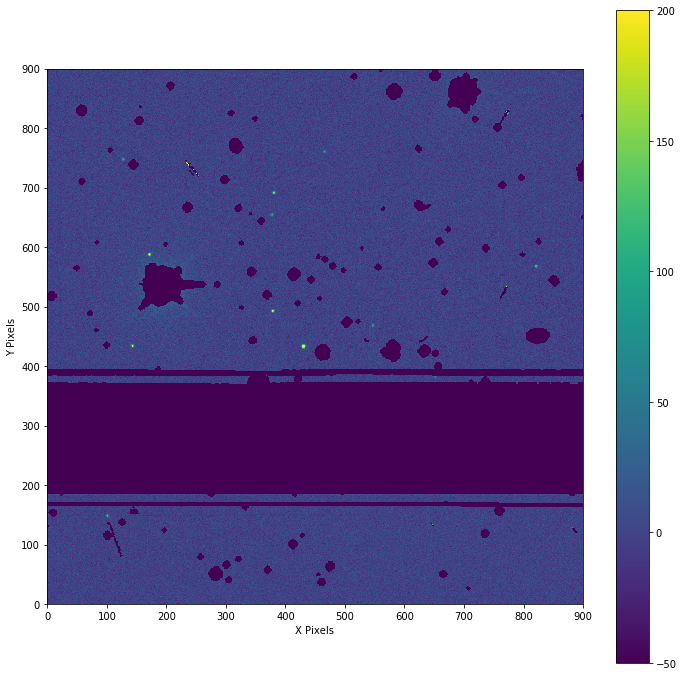

In [20]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [21]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [22]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [23]:
search.get_results(0,20)

[lh: 265.922638 flux: 9375.439453 x: 3123 y: 3043 x_v: 2424.693359 y_v: 1044.252075 obs_count: 3,
 lh: 265.236328 flux: 9452.645508 x: 3124 y: 3042 x_v: 2421.198975 y_v: 1052.328613 obs_count: 3,
 lh: 264.632080 flux: 10012.237305 x: 3124 y: 3043 x_v: 2424.693359 y_v: 1044.252075 obs_count: 3,
 lh: 264.317200 flux: 9500.118164 x: 3124 y: 3045 x_v: 2418.963135 y_v: 1032.239136 obs_count: 3,
 lh: 262.467834 flux: 9389.625000 x: 3122 y: 3042 x_v: 2433.877686 y_v: 1048.207642 obs_count: 3,
 lh: 260.334198 flux: 9106.463867 x: 3121 y: 3044 x_v: 2437.358154 y_v: 1040.088867 obs_count: 3,
 lh: 260.334198 flux: 9106.463867 x: 3122 y: 3044 x_v: 2428.160645 y_v: 1036.164062 obs_count: 3,
 lh: 260.170776 flux: 9792.182617 x: 3123 y: 3044 x_v: 2428.160645 y_v: 1036.164062 obs_count: 3,
 lh: 260.170776 flux: 9792.182617 x: 3122 y: 3044 x_v: 2437.358154 y_v: 1040.088867 obs_count: 3,
 lh: 257.498840 flux: 8984.563477 x: 3124 y: 3041 x_v: 2417.677734 y_v: 1060.393433 obs_count: 3,
 lh: 256.795593 flu

In [24]:
#search.region_search(2400, 1040, 50, 255, 3)
res = search.region_search(2000, 1000, 850, 10, 3)

In [25]:
print(len(res))
res

748


[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 1408.000000 iy: 706.000000 fx: 1891.000000 fy: 815.000000 depth: 0 obs_count: 4 lh: 175.542313 flux 3700.730957,
 ix: 880.000000 iy: 1308.000000 fx: 1316.000000 fy: 1431.000000 depth: 0 obs_count: 4 lh: 174.796127 flux 3644.377441,
 ix: 150.000000 iy: 1977.000000 fx: 623.000000 fy: 2175.000000 depth: 0 obs_count: 4 lh: 173.163834 flux 3633.026855,
 ix: 2926.000000 iy: 463.000000 fx: 3335.000000 fy: 683.000000 depth: 0 obs_count: 4 lh: 173.155365 flux 3666.797607,
 ix: 1581.000000 iy: 2547.000000 fx: 2139.000000 fy: 2703.000000 depth: 0 obs_count: 4 lh: 171.372391 flux 3613.570557,
 ix: 3437.000000 iy: 1699.000000 fx: 3887.000000 fy: 1818.000000 depth: 0 obs_count: 4 lh: 171.286865 flux 3564.412109,
 ix: 2758.000000 iy: 2276.000000 fx: 3160.000000 fy: 2396.000000 depth: 0 obs_count: 4 lh: 169.473785 flux 3528.860840,
 ix: 1336.000000 iy: 1338.000000 fx: 1750.00000

In [26]:
matched = []
for r in res:
    if any(abs(r.ix-t.x)<=1 and abs(r.iy-t.y)<=1 for t in results_key ):
        matched.append(r)
len(matched)

179

In [27]:
matched

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 1408.000000 iy: 706.000000 fx: 1891.000000 fy: 815.000000 depth: 0 obs_count: 4 lh: 175.542313 flux 3700.730957,
 ix: 880.000000 iy: 1308.000000 fx: 1316.000000 fy: 1431.000000 depth: 0 obs_count: 4 lh: 174.796127 flux 3644.377441,
 ix: 150.000000 iy: 1977.000000 fx: 623.000000 fy: 2175.000000 depth: 0 obs_count: 4 lh: 173.163834 flux 3633.026855,
 ix: 2926.000000 iy: 463.000000 fx: 3335.000000 fy: 683.000000 depth: 0 obs_count: 4 lh: 173.155365 flux 3666.797607,
 ix: 1581.000000 iy: 2547.000000 fx: 2139.000000 fy: 2703.000000 depth: 0 obs_count: 4 lh: 171.372391 flux 3613.570557,
 ix: 3437.000000 iy: 1699.000000 fx: 3887.000000 fy: 1818.000000 depth: 0 obs_count: 4 lh: 171.286865 flux 3564.412109,
 ix: 2758.000000 iy: 2276.000000 fx: 3160.000000 fy: 2396.000000 depth: 0 obs_count: 4 lh: 169.473785 flux 3528.860840,
 ix: 1336.000000 iy: 1338.000000 fx: 1750.00000

# Examining Pooling

In [28]:
pooled = search.get_psi_pooled()

In [52]:
pooled_imgs = [np.array(im, copy=False) for im in pooled[1]]

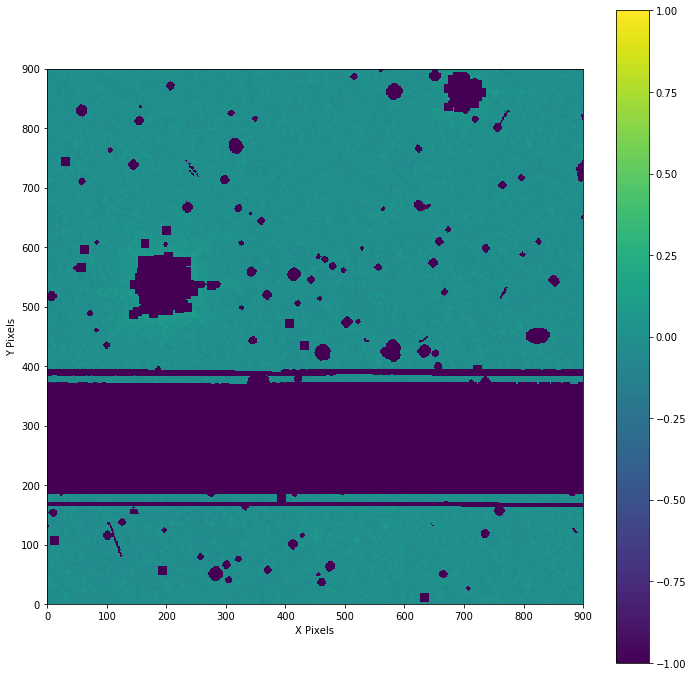

In [53]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[0] [2700:3600,2900:3800], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

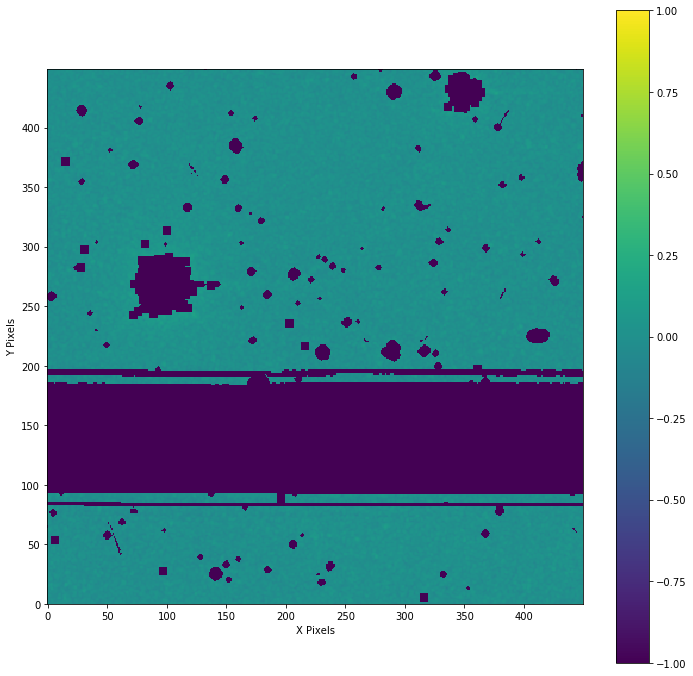

In [54]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[1] [1350:1800,1450:1900], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

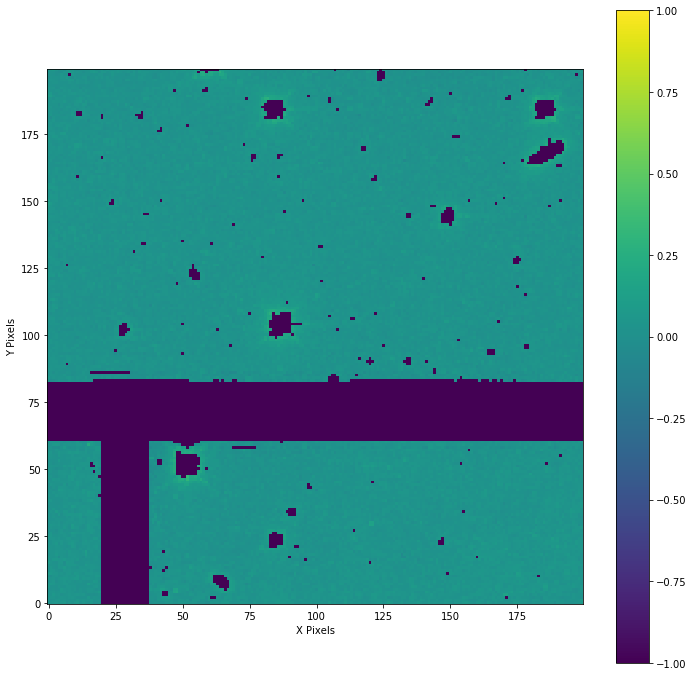

In [75]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[3] [300:500,300:500], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()